In [4]:
###importing libraries

import pandas as pd
import numpy as np
import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec

#for handling imbalance in the dataset

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import cross_val_score

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

In [3]:
#optional settings for exploratory analysis
pd.set_option("display.max_colwidth", None)

### Input output functions

In [4]:
def read_input(file):
    """
    Reads input file into pandas dataframe
    file : path of the file
    return : pandas dataframe
    """
    input_file = pd.read_feather(file)
    return input_file

### Text Processing functions

In [91]:
def conv_to_str(input_file, column_name):
    """
    converts the feature to str
    input_file : pandas dataframe
    column_name : feature name
    return : connverted feature name as str type
    """
    input_file[column_name] = input_file[column_name].astype(str)
    return input_file


def preprocess(text):
    """
    It does the following in order:
    1.Converts text to lowercase
    2.Strips of leading, trailing white spaces
    3.Removes special characters
    4.Removes punctuations
    5.Removes extra white spaces
    6.Removes digits
    7.Removes any other whitespaces
    8.Remove other digit characters
    text: text to process
    return: clean text
    """
    text = text.lower() 
    text = text.strip()  
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'(^| ).( |$)',' ', text)
    return text

def remove_stopwords(text):
    """
    removes stopwords from the text
    text : text to process
    return: text with removed stopwords
    """
    a= [word for word in text.split() if word not in stopwords.words('english')]
    return ' '.join(a)


def lemmatize(text):
    """
    Reduce the text to it's orginal form depending on it's tag
    text : text to process
    return : lemmatized text
    """
    
    wn = WordNetLemmatizer()
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    word_pos_tags = nltk.pos_tag(word_tokenize(text))
    a=[wn.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)

def all_preprocess(string):
    """
    Combines all the text preprocessing steps
    string: text to process
    return : clean text 
    """
    return remove_stopwords(preprocess(string))

### main function

In [6]:
if __name__ == "__main__":
    
    #read in the input data
    data = read_input('data/train.feather')
    

## Exploratory data analysis - Basic statistics , Feature Engineering & Feature Selection

###### Total number of rows : 607844
###### No duplicates
###### Number of features : 23
###### 733 distinct queries
###### Features like 'crossorigin', 'ismap', 'loading', 'longdesc',' referrerpolicy', 'sizes', 'srcset', 'style', have more 80% of missing values (shown as below) in them and doesn't make sense to include in them in the model. Hence all of them are dropped 


In [7]:
data.isnull().sum() * 100 / len(data)

query              0.000000
url_page           0.000000
title              0.000000
source             0.000000
alt               15.009114
src                0.000000
crossorigin       99.947684
height            59.597693
ismap             99.998519
loading           80.367496
longdesc          99.758326
referrerpolicy    99.946697
sizes             89.308605
srcset            82.591257
width             57.822895
class             49.008298
style             87.183718
tree_path          0.000000
deg               30.277999
text_tag          30.277999
text              30.277999
id                 0.000000
is_relevant        0.000000
dtype: float64

In [8]:
# Drop columns
data.drop(columns=['crossorigin', 'height', 'ismap', 'loading', 'longdesc', 'referrerpolicy', 'sizes', 'srcset','style'], inplace = True)

###### Features like 'width', 'class', 'deg', 'text_tag', 'tree_path' don't have any real information that can add value to the text description we want to build and hence are removed on heuristic basics

###### Text in 'url_page' is more specific compared to the 'source' feature and might only create more deviation from the prediction . Hence is removed

##### Feature 'text' add more descriptions to the exact image and hence it is retained


In [9]:
# Drop columns based on heuristics
data.drop(columns=['width', 'class', 'deg', 'text_tag', 'tree_path', 'source'], inplace = True)

0    586007
1     21837
Name: is_relevant, dtype: int64


<Axes: ylabel='is_relevant'>

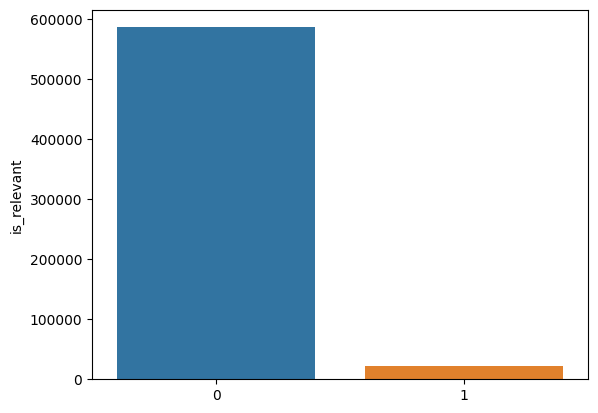

In [69]:
#Target feature distribution
print(data.is_relevant.value_counts())

sns.barplot(x=data.is_relevant.value_counts().index, y=data.is_relevant.value_counts())

#### data is imbalanced , there 96% of 0 compared to 1 , hence balancing techniques need to be applied while building the model

#### Text preprocessing

In [100]:
# Preprocessing text 

# data['clean_text'] = data['combined_text'].apply(lambda x: all_preprocess(x))

In [101]:
data['clean_query'] = data['query'].apply(lambda x: all_preprocess(x))

In [110]:
data['clean_url_page'] = data['url_page'].apply(lambda x: all_preprocess(x))

In [113]:
data['clean_title'] = data['title'].apply(lambda x: all_preprocess(x))

In [114]:
data['clean_src'] = data['src'].apply(lambda x: all_preprocess(x))

In [116]:
data['clean_alt'] = data['alt'].apply(lambda x: all_preprocess(x))

In [135]:
data['clean_text'] = data['text'].apply(lambda x: all_preprocess(x))

In [151]:
# Merge all of the text columns to form one feature variable for prediction
data['combined_text'] = data[['clean_query', 'clean_url_page', 'clean_title', 'clean_alt', 'clean_src', 'clean_text' ]].agg(' '.join, axis=1)

In [140]:
# word count
data['combined_text'].apply(lambda x: len(str(x).split())).describe()

count    607844.000000
mean        129.229791
std        1250.899271
min           9.000000
25%          30.000000
50%          38.000000
75%          52.000000
max       76563.000000
Name: combined_text, dtype: float64

In [122]:
data['clean_src'].apply(lambda x: len(str(x).split())).describe()

count    607844.000000
mean         12.852143
std          57.935121
min           1.000000
25%           9.000000
50%          11.000000
75%          14.000000
max       44478.000000
Name: clean_src, dtype: float64

##### TRAINING AND SPLITTING

In [152]:
# Input: "clean_text"
# Target: "is_relevant"
# X_train, X_test, y_train, y_test = train_test_split(data["clean_text"],
#                                                   data["is_relevant"],
#                                                   test_size=0.2,
#                                                   shuffle=True)

# print(y_train.value_counts())

# print(y_test.value_counts())

#Handling imbalance in the data 
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.20,
                             random_state=0)

for train, test in splitter.split(data["combined_text"], data["is_relevant"]):
    X_train = data["combined_text"].iloc[train]
    y_train = data["is_relevant"].iloc[train]
    X_test = data["combined_text"].iloc[test]
    y_test = data["is_relevant"].iloc[test]
    
    

print(y_train.value_counts())
print(y_test.value_counts())

0    468805
1     17470
Name: is_relevant, dtype: int64
0    117202
1      4367
Name: is_relevant, dtype: int64


##### VECTORIZATION

In [153]:
#using tf-idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [174]:
#using word2vec

data['clean_text_tok']=[nltk.word_tokenize(i) for i in data['combined_text']]

In [175]:
w2v_model = gensim.models.Word2Vec(data['clean_text_tok'], vector_size=100, window=5, min_count=5, workers=4)

In [185]:
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 

In [ ]:
#embedding function to get the mean of all vectors
class MeanEmbeddingVectorizer(object):
    """
    Calculates the mean of all vectors of the words in a document
    """
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [188]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_test_tok= [nltk.word_tokenize(i) for i in X_test]      #for word2vec

In [192]:
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

##### MODEL BUILDING

#### LOGISTIC REGRESSION(TF-IDF)

In [154]:
# logistic regression model
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight = 'balanced')

#fit the model
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Prediction
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Auc Score: ", roc_auc_score(y_test, y_predict))



Confusion Matrix: [[106268  10934]
 [  2599   1768]]

 Auc Score:  0.6557813339532791


#### NAIVE BAYES(TF-IDF)

In [155]:
# Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  


#Prediction
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]


print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print (roc_auc_score(y_test, y_predict))

Confusion Matrix: [[117164     38]
 [  4361      6]]
0.5005248571857528


#### ADA BOOSTING (TF-IDF)

In [163]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
 
# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=2)
ad_boost = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)

# Creating the model on Training Data
AB=ad_boost.fit(X_train_vectors_tfidf, y_train)
prediction=AB.predict(X_test_vectors_tfidf)
 
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print (roc_auc_score(y_test, y_predict))
 

/Users/akalya/VENV/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Confusion Matrix: [[117164     38]
 [  4361      6]]
0.5005248571857528


#### LOGISTIC REGRESSION (WORD2VEC)

In [3]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', class_weight = 'balanced')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
print ("\n Auc Score: ", roc_auc_score(y_test, y_predict))

 

NameError: name 'X_train_vectors_w2v' is not defined

In [2]:
import tensorflow as tf

ModuleNotFoundError: No module named 'tensorflow'